In [1]:
from pickle import load

import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from keras_tuner import BayesianOptimization, Objective
from tensorflow.keras import callbacks, models

from progtools.preprocessing import RawFlightData, DataStructure, CreateShapValues
from progtools.modelling import gpu_check, RemainingUsefulLifeHyperModel
from progtools.scoring import rul_scoring
from progtools.visuals import unit_plots

import plotly.express as px
import plotly.io as pio

pio.templates.default="simple_white"

In [2]:
#check that TensorFlow is able to detect the GPU
gpu_check()

GPU Ready and available


# Import and Prepare Data

In [3]:
#read the raw flight data in
filename = "data/N-CMAPSS_DS05.h5"
raw_data_read = RawFlightData(filename=filename)

#create the full dataset dataframes
df_W = raw_data_read.all_flight_data()
df_X_s = raw_data_read.all_sensor_data()
df_A = raw_data_read.all_aux_data()
df_Y = raw_data_read.all_RUL_data()

In [4]:
#downsample for faster model iteration
sample_index = np.arange(1,max(df_A.index),10)

df_W = df_W.loc[sample_index]
df_X_s = df_X_s.loc[sample_index]
df_A = df_A.loc[sample_index]
df_Y = df_Y.loc[sample_index]

In [5]:
#create seperate dataframes for 9-parameter and 14-parameter datasets
df_X_9=pd.concat([df_X_s[["Wf","T24","T30","T48","T50","P24","Ps30","P40","P50"]], df_W],axis=1)
df_X_14=pd.concat([df_X_s, df_W],axis=1)

In [6]:
#load the scalers for 9-parameter and 14-parameter scalers
X_scaler_9 = load(open("prognostic_models/9_Parameter_Prognostic_Scaler.pkl","rb"))
X_scaler_14 = load(open("prognostic_models/14_Parameter_Prognostic_Scaler.pkl","rb"))

In [7]:
#scale the input data with their respective scalers
X_9_scaled = X_scaler_9.transform(np.asarray(df_X_9))
X_14_scaled = X_scaler_14.transform(np.asarray(df_X_14))

In [8]:
#wrangle back into dataframes for structuring
df_X_9 = pd.DataFrame(data=X_9_scaled,
                      index=df_X_9.index,
                      columns=df_X_9.columns)

df_X_14 = pd.DataFrame(data=X_14_scaled,
                       index=df_X_14.index,
                       columns=df_X_14.columns)

In [9]:
master_9_param = DataStructure(df_X_9,
                               df_Y,
                               df_A)

master_14_param = DataStructure(df_X_14,
                                df_Y,
                                df_A)

In [10]:
true_target = master_9_param.create_y(piece_wise=False)
pw_target = master_9_param.create_y(piece_wise=True)

100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


In [11]:
#check the true target is the true target with a quick line plot
px.line(true_target,
        x="cycle",
        y="RUL",
        color="unit")

In [12]:
#check the piecewise target is the piecewise target with a quick line plot
px.line(pw_target,
        x="cycle",
        y="RUL",
        color="unit")

In [13]:
X_9 = np.asarray(master_9_param.create_X(2000))
X_14 = np.asarray(master_14_param.create_X(2000))

y_true = np.asarray(true_target["RUL"])
y_pw = np.asarray(pw_target["RUL"])

100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


In [14]:
#print out results to check all shapes match up
print(f"9-Parameter Input Data Shape:{np.shape(X_9)}")
print(f"14-Parameter Input Data Shape: {np.shape(X_14)}")
print(f"True RUL Target Data Shape: {np.shape(y_true)}")
print(f"Piece-wise RUL Target Data Shape: {np.shape(y_pw)}")

9-Parameter Input Data Shape:(818, 2000, 13)
14-Parameter Input Data Shape: (818, 2000, 18)
True RUL Target Data Shape: (818,)
Piece-wise RUL Target Data Shape: (818,)


In [15]:
#load the individual models for 9-parameter and 14-parameter models
model_9 = models.load_model("prognostic_models/9_Parameter_Prognostic_Model.h5")
model_14 = models.load_model("prognostic_models/14_Parameter_Prognostic_Model.h5")

In [16]:
#create predictions on the evaluation data for each model
y_9_pred = model_9.predict(X_9)
y_14_pred = model_14.predict(X_14)

# Create Results DataFrames

In [17]:
#create a dataframe joining the piece-wise target, with the predictions for the 9-parameter model
df_results_pw_9 = pw_target.join(pd.DataFrame(y_9_pred, columns=["yhat"]))

#calculate the square of the difference between prediction and ground-truth to calculate individual RMSE scores by unit
df_results_pw_9["delta_sq"]=(df_results_pw_9["RUL"]-df_results_pw_9["yhat"])**2

In [18]:
#create a dataframe joining the piece-wise target, with the predictions for the 14-parameter model
df_results_pw_14 = pw_target.join(pd.DataFrame(y_14_pred, columns=["yhat"]))

#calculate the square of the difference between prediction and ground-truth to calculate individual RMSE scores by unit
df_results_pw_14["delta_sq"]=(df_results_pw_14["RUL"]-df_results_pw_14["yhat"])**2

In [19]:
#create a dataframe joining the true target, with the predictions for the 9-parameter model
df_results_true_9 = true_target.join(pd.DataFrame(y_9_pred, columns=["yhat"]))

#calculate the square of the difference between prediction and ground-truth to calculate individual RMSE scores by unit
df_results_true_9["delta_sq"]=(df_results_true_9["RUL"]-df_results_true_9["yhat"])**2

In [20]:
#create a dataframe joining the true target, with the predictions for the 14-parameter model
df_results_true_14 = true_target.join(pd.DataFrame(y_14_pred, columns=["yhat"]))

#calculate the square of the difference between prediction and ground-truth to calculate individual RMSE scores by unit
df_results_true_14["delta_sq"]=(df_results_true_14["RUL"]-df_results_true_14["yhat"])**2

In [21]:
#apply strings to the target column
df_results_pw_9["target"]="piecewise"
df_results_pw_9["model"]="9-parameter"

df_results_pw_14["target"]="piecewise"
df_results_pw_14["model"]="14-parameter"

df_results_true_9["target"]="true"
df_results_true_9["model"]="9-parameter"

df_results_true_14["target"]="true"
df_results_true_14["model"]="14-parameter"

#concatenate all results into a single dataframe
df_results = pd.concat([df_results_pw_9, df_results_pw_14, df_results_true_9, df_results_true_14])

#apply strings to the hs column
df_results["hs"] = df_results["hs"].apply(lambda x: "healthy" if x==1 else "unhealthy")

#reset the index for plotting
df_results.reset_index(inplace=True)

In [22]:
#group by unit, target, hs and model to calculate the mean MSE for each group
df_results = df_results.groupby(["target", "model", "hs", "unit"],group_keys=False).agg({"delta_sq":"mean"}).reset_index()

In [23]:
df_results["RMSE"] = np.sqrt(df_results["delta_sq"]).drop(columns=["delta_sq"])

# Scoring versus RMSE & NASA Functions

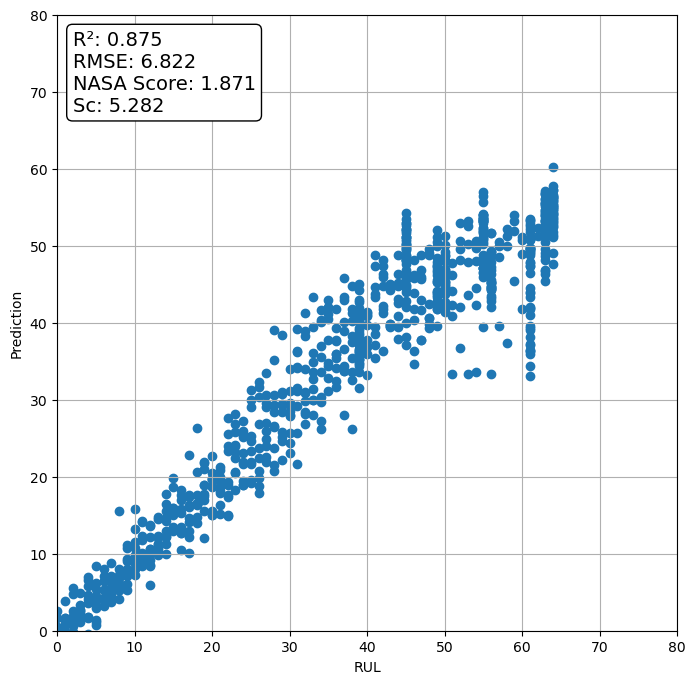

In [24]:
#exmaine the results of the evaluation predictions against the piecewise target for the 9-parameter model
rul_scoring(y_pw, y_9_pred)

In [25]:
#plot out piecewise target versus prediction with RMSE for 9-parameter model
unit_plots(df_results_pw_9, title="9-Parameter Model")

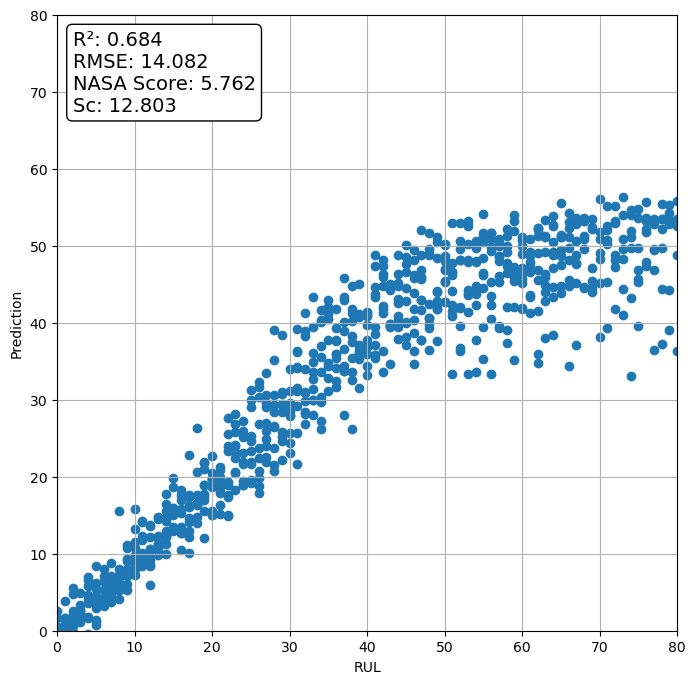

In [26]:
#exmaine the results of the evaluation predictions against the true target for the 9-parameter model
rul_scoring(y_true, y_9_pred)

In [27]:
#plot out true target versus prediction with RMSE for 9-parameter model
unit_plots(df_results_true_9, title="9-Paramter Model")

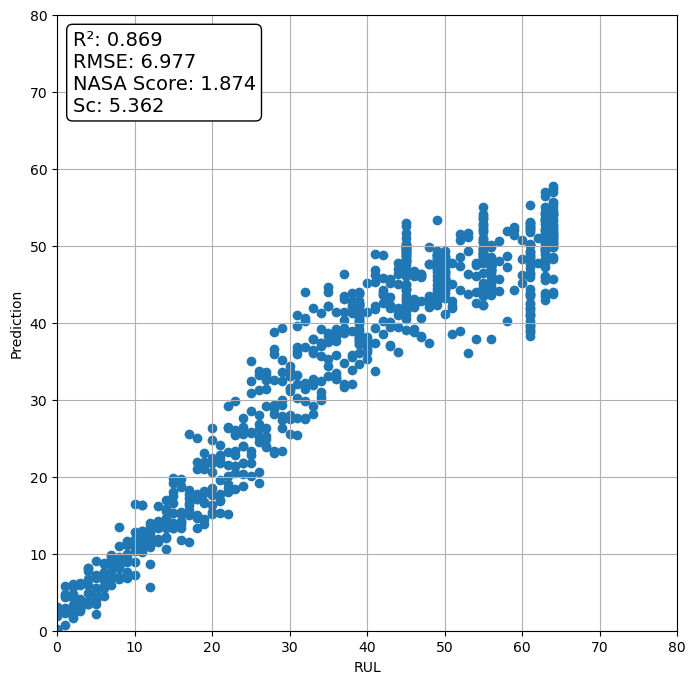

In [28]:
#exmaine the results of the evaluation predictions against the piecewise target for the 14-parameter model
rul_scoring(y_pw, y_14_pred)

In [29]:
#plot out piecewise target versus prediction with RMSE for 14-parameter model
unit_plots(df_results_pw_14,title="14-Parameter Model")

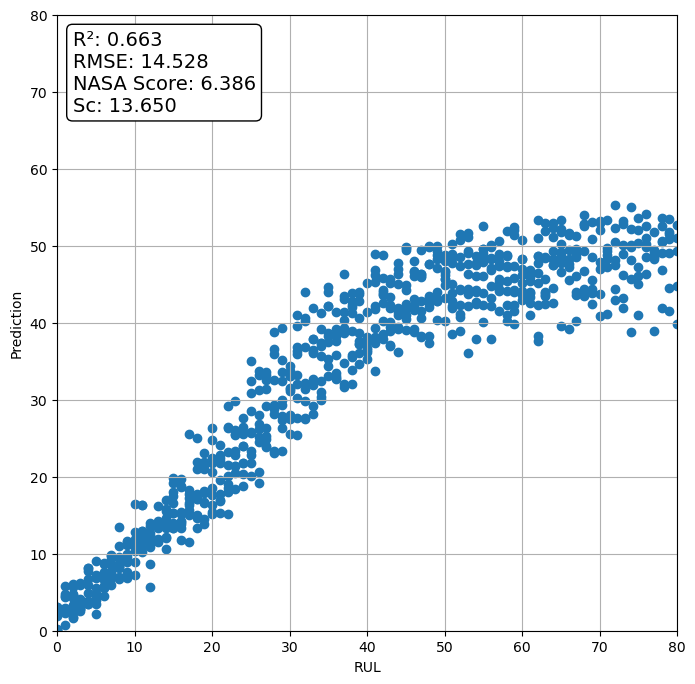

In [30]:
#exmaine the results of the evaluation predictions against the true target for the 14-parameter model
rul_scoring(y_true, y_14_pred)

In [31]:
#plot out true target versus prediction with RMSE for 14-parameter model
unit_plots(df_results_true_14)

# Test Statistic Between Models

In [32]:
#complete a Mann-Whitney U test between predictions of 9-paramter and 14-parameter model
test_stat, p_val = mannwhitneyu(y_14_pred[:,0],
                                y_9_pred[:,0])

print(f"Test statistic: {test_stat:.3f}, P-Value: {p_val:.3f}")

Test statistic: 334379.000, P-Value: 0.985


# Comparative Assessment

In [33]:
#create seperate piecewise and true target dataframes
df_results_true = df_results[df_results["target"]=="true"]
df_results_piecewise = df_results[df_results["target"]=="piecewise"]

In [34]:
#Boxplot of RSME for true RUL target for 9 and 14 parameter models, by color of heath-state
px.box(df_results_true,
      x="model",
      y="RMSE",
      color="hs",
      title="Boxplot of RMSE for 9 Parameter vs. 14 Parameter Models: True RUL Target")

In [35]:
#Boxplot of RSME for piecewise RUL target for 9 and 14 parameter models, by color of heath-state
px.box(df_results_piecewise,
      x="model",
      y="RMSE",
      color="hs",
      title="Boxplot of RMSE for 9 Parameter vs. 14 Parameter Models: Piecewise RUL Target")

In [36]:
#split out healthy and unhealthy results into seperate dataframes
df_healthy_true = df_results_true[df_results_true["hs"]=="healthy"]
df_unhealthy_true = df_results_true[df_results_true["hs"]=="unhealthy"]

In [37]:
#Complete Mann-Whitney U test of 9-parameter predictions versus 14-parameter predictions during healthy phase
test_stat, p_val = mannwhitneyu(df_healthy_true[df_healthy_true["model"]=="9-parameter"]["RMSE"],
                                df_healthy_true[df_healthy_true["model"]=="14-parameter"]["RMSE"])

print(f"Test statistic: {test_stat:.3f}, P-Value: {p_val:.3f}")

Test statistic: 51.000, P-Value: 0.970


In [38]:
#Complete Mann-Whitney U test of 9-parameter predictions versus 14-parameter predictions during unhealthy phase
test_stat, p_val = mannwhitneyu(df_unhealthy_true[df_unhealthy_true["model"]=="9-parameter"]["RMSE"],
                                df_unhealthy_true[df_unhealthy_true["model"]=="14-parameter"]["RMSE"])

print(f"Test statistic: {test_stat:.3f}, P-Value: {p_val:.3f}")

Test statistic: 42.000, P-Value: 0.571


In [39]:
#split out training and test samples
df_train_true = df_results_true[df_results_true["unit"]<=6]
df_test_true = df_results_true[df_results_true["unit"]>6]

In [40]:
#Complete Mann-Whitney U test for training versus test sets for 9-parameter model
test_stat, p_val = mannwhitneyu(df_train_true[df_train_true["model"]=="9-parameter"]["RMSE"],
                                df_test_true[df_test_true["model"]=="9-parameter"]["RMSE"])

print(f"Test statistic: {test_stat:.3f}, P-Value: {p_val:.3f}")

Test statistic: 48.000, P-Value: 1.000


In [41]:
#Complete Mann-Whitney U test for training versus test sets for 14-parameter model
test_stat, p_val = mannwhitneyu(df_train_true[df_train_true["model"]=="14-parameter"]["RMSE"],
                                df_test_true[df_test_true["model"]=="14-parameter"]["RMSE"])

print(f"Test statistic: {test_stat:.3f}, P-Value: {p_val:.3f}")

Test statistic: 49.000, P-Value: 0.970


# Export SHAP Values

### Create a dataframe of units and cycles to match the index of the modelled data

In [42]:
#create a dataframe of units and cycles to match the index of the modelled data at 0.1 Hz
u_c = []

#loop through each unit
for u in df_A["unit"].unique():
    #loop through each cycle of selected unit
    for c in df_A[df_A["unit"]==u]["cycle"].unique():
        unit_list=[u]*2000 #create a list of 2000 units
        cycle_list=[c]*2000 #create a list of 2000 cycles

        # create a list to store the columns
        columns = []

        # iterate over the two lists simultaneously using zip()
        for unit, cycle in zip(unit_list, cycle_list):
            columns.append([unit, cycle])
        u_c.append(columns)

u_c = np.asarray(u_c)

### SHAP Values for Next Notebook

In [ ]:
shap_9 = CreateShapValues(model_in=model_9,
                          sample_in=X_9,
                          sample_size=100,
                          features=df_X_9.columns)  

In [ ]:
shap_9.expected_value_

In [ ]:
df_u_c9 = pd.DataFrame(u_c[shap_9.shap_index_].reshape(2000*100,2), columns=["unit", "cycle"])

In [ ]:
pd.concat([df_u_c9, shap_9.create_shap_values(), shap_9.create_predictor_values(X_scaler_9)], axis=1).to_csv("SHAP_Values_9_Model.csv")

In [43]:
shap_14 = CreateShapValues(model_in=model_14,
                           sample_in=X_14,
                           sample_size=100,
                           features=df_X_14.columns)

c:\Users\carlw\.conda\envs\TensorFlow2\lib\site-packages\shap\explainers\_deep\deep_tf.py:100: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



In [44]:
shap_14.expected_value_

<tf.Tensor: shape=(), dtype=float32, numpy=33.65445>

In [45]:
df_u_c14 = pd.DataFrame(u_c[shap_14.shap_index_].reshape(2000*100,2), columns=["unit", "cycle"])

In [46]:
pd.concat([df_u_c14, shap_14.create_shap_values(), shap_14.create_predictor_values(X_scaler_14)], axis=1).to_csv("SHAP_Values_14_Model.csv")

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\carlw\AppData\Roaming\Python\Python39\site-packages\keras\backend.py:450: UserWarning:

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.

100%|██████████| 100/100 [00:00<?, ?it/s]
